In [1]:
import fastai
from fastai import *
from fastai.text import * 
from fastai.tabular import *
from fastai.text.models import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import swifter
import nltk
from nltk.corpus import stopwords
import re 
from bs4 import BeautifulSoup
from sklearn.metrics import precision_score, recall_score
from nltk.stem.snowball import SnowballStemmer

In [2]:
DATA_PATH = Path('Input_data')
MODEL_LM_PATH = Path('models_lm')
MODEL_LM_PATH.mkdir(exist_ok=True)
MODEL_TEXT_TAB_PATH = Path('models_text_tab')
MODEL_TEXT_TAB_PATH.mkdir(exist_ok=True)

In [3]:
def update_category(row, category):
    sentiment = row['Sentiment']
    categories = str(row['Categories']).split(";")
    if category in categories:
        return sentiment
    else:
        return 2

In [4]:
corrected = pd.read_csv('Input_data/corrected.csv')

In [5]:
#dropping the two columns and filter only English
corrected=corrected.drop(columns=['pred'])

In [6]:
corrected.set_index('Unnamed: 0', inplace=True)

In [7]:
fulldata= pd.read_csv('Input_data/newdata.csv')

In [8]:
fulldata.drop(columns=['raw_text', 'pred', 'Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [9]:
fulldata_noneng = fulldata[fulldata['Language']!='eng']

In [10]:
fulldata = pd.concat([corrected, fulldata_noneng])

In [11]:
fulldata.sort_index(inplace=True)

In [12]:
#fulldata['Sentiment']= fulldata['Sentiment'].apply(lambda x: x if x in [0,1] else 2)

In [13]:
fulldata['food'] = fulldata.apply(update_category,args=('food',), axis=1)
fulldata['experience'] = fulldata.apply(update_category,args=('experience',), axis=1)
fulldata['service'] = fulldata.apply(update_category,args=('service',), axis=1)
fulldata['value'] = fulldata.apply(update_category,args=('value',), axis=1)
fulldata['consistency'] = fulldata.apply(update_category,args=('consistency',), axis=1)
fulldata['convenience'] = fulldata.apply(update_category,args=('convenience',), axis=1)

fulldata['Integration Type']= fulldata['Integration Type'].astype('category')
fulldata['Language']= fulldata['Language'].astype('category')

In [14]:
df_train = fulldata[:8000]
df_valid = fulldata[8000:]

In [15]:
val_idxs = np.arange(df_train.shape[0], fulldata.shape[0])

In [16]:
bs = 64

# create Databunch (https://docs.fast.ai/text.data.html)
data_lm = (TextList.from_df(fulldata, cols=['Text'])
                           .split_by_idx(val_idxs)
                           .label_for_lm()  
                           .databunch(path=MODEL_LM_PATH, bs=bs))

In [17]:
data_lm.save('data_lm.pkl')

In [18]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.5, path=MODEL_LM_PATH)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 3.02E-02


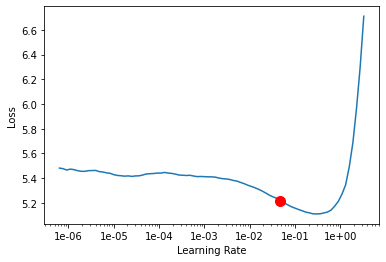

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_lr = learn.recorder.min_grad_lr

In [20]:
learn.fit_one_cycle(1, min_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.344025,3.892704,0.283431,00:20


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 1.10E-03


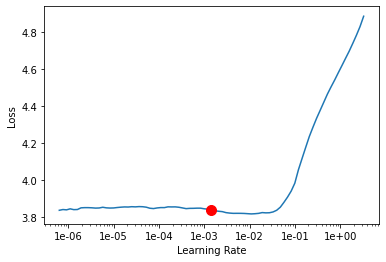

In [21]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_lr = learn.recorder.min_grad_lr

In [22]:
learn.fit_one_cycle(2, min_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.748312,3.763019,0.295992,00:21
1,3.577335,3.727427,0.300852,00:22


In [23]:
learn.save_encoder('fine_tuned_enc')

In [24]:
cat_names = ['Integration Type', 'Language'] # categorical
cont_names = [] # continous variables (in our case we don't have any) 
dep_vars = ['Sentiment', 'food', 'experience', 'consistency','service', 'value'] # label
txt_cols=['Text'] # text
bs = 64 # batch size
procs = [FillMissing, Categorify, Normalize]

In [25]:
def get_text_databunch(df,bs=bs,val_idxs=val_idxs, path = MODEL_TEXT_TAB_PATH):
    # load fine-tuned vocab
    data_lm =load_data(MODEL_LM_PATH, 'data_lm.pkl', bs=bs)
    return (TextList.from_df(df, cols = txt_cols[0], vocab=data_lm.vocab, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols=dep_vars)
                            .databunch(bs=bs))

In [26]:
def get_text_learner(data, params):
    learn = text_classifier_learner(data,AWD_LSTM,metrics=accuracy,**params)
    learn.path=MODEL_LM_PATH
    learn.load_encoder('fine_tuned_enc')
    learn.path=MODEL_TEXT_TAB_PATH
    return learn

In [27]:
class ConcatDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __len__(self): 
        return len(self.y)
    def __getitem__(self, i): 
        return self.x[i], self.y[i]

In [28]:
def get_data(bs=bs,path=MODEL_TEXT_TAB_PATH):
    
    # get databunches using fast.ai's implementation

    text_db = get_text_databunch(fulldata[txt_cols +dep_vars])
    
    # extend the databunches to work with our Concat Model
    train_ds = ConcatDataset(text_db.train_ds.x, text_db.train_ds.y)
    valid_ds = ConcatDataset(text_db.valid_ds.x, text_db.valid_ds.y)
    
    # add sample startegies for both training and validation set
    train_sampler = SortishSampler(text_db.train_ds.x, key=lambda t: len(text_db.train_ds[t][0].data), bs=bs//2)
    valid_sampler = SortSampler(text_db.valid_ds.x, key=lambda t: len(text_db.valid_ds[t][0].data))
    
    # create DataLoaders
    train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler)
    valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
    
    # create databunch to work with out Concat Model
    data = DataBunch(train_dl, valid_dl, device=defaults.device, path=path)

    return data,text_db

In [29]:
data,text_db = get_data(bs=bs)

In [30]:
params = {
    'lin_ftrs': [50],  # output size of the last layer of the text module (ULMFiT)
    'bptt': 80, # backpropagation through time (sequence length)
    'max_len': 20*80, # last max_len activations to be considered (see https://docs.fast.ai/text.learner.html)
    'drop_mult': 0.2 # dropout rate
}

In [31]:
learn = text_classifier_learner(text_db,AWD_LSTM,metrics=accuracy, drop_mult=0.3)
learn.path=MODEL_LM_PATH
learn.load_encoder('fine_tuned_enc')
learn.path=MODEL_TEXT_TAB_PATH

In [32]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 332.00 MiB (GPU 0; 7.43 GiB total capacity; 6.31 GiB already allocated; 316.44 MiB free; 6.60 GiB reserved in total by PyTorch)